# PycWB Tutorial

## 0. Install dependencies

<!-- You can create the environment with conda, this will cost around 10 mins

```python
!pip install -q condacolab
import condacolab
condacolab.install()
```

```python
!conda install -c conda-forge -y -q healpix_cxx=3.81 root=6.26.10 cmake pkg-config
!conda install -c conda-forge -y -q nds2-client python-nds2-client
```

Here, to save the time. We download the ROOT binaries and other dependencies with `apt-get` -->

In [ ]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

✨🍰✨ Everything looks OK!


**since I am using anaconda, this part is not needed**

In [ ]:
# !mamba install -c conda-forge -y -q healpix_cxx=3.81 root=6.26.10 cmake pkg-config
# !mamba install -c conda-forge -y -q nds2-client python-nds2-client

**root 6.28 is not compatible**

**Windows is not compatible, thus I turned to use wsl-Ubuntu**

### Install pycwb package

In [ ]:
# !git clone https://github.com/PycWB/pycwb.git

**Github is no longer accessable in Chinese mainland by using common proxy resantly due to Microsoft supports, one possible way is to use _miltihops_**

**But I asked classmate abroad to clone that for me**

In [ ]:
# !cd pycwb && git reset --hard d1d26df && pip install .

**Here we have to do the reset, latest pycwb (see document) is not compatible**

In [ ]:
# !pip install pycwb
# !pip install "astropy<5.3" "matplotlib<3.7.0"

### Install deps for modules

In [ ]:
# !pip install -q basemap healpy tensorflow

**I recommand to use mamba, which is much more faster**

## 1. Run your first example

First, we download the example user parameter file

In [1]:
user_parameters = """
analysis: "2G"
cfg_search: "r"

optim: False

###### network configuration ######
ifo: ["L1","H1"]
refIFO: "L1"

inRate: 16384
# lags
lagSize: 1
lagStep: 1.
lagOff: 0
lagMax: 0

# superlags
slagSize: 0 # number of super lags (simulation=1) - if slagSize=0 -> Standard Segments
slagMin: 0
slagMax: 0
slagOff: 0

# job
segLen: 1200
segMLS: 600
segTHR: 200
segEdge: 10

# frequency
fLow: 16.
fHigh: 1024.


levelR: 3
l_low: 4 # low frequency resolution level		// std (sthr = 2)
l_high: 10 # high frequency resolution level	// std (sthr = 8)

wdmXTalk: "wdmXTalk/OverlapCatalog16-1024.bin"

healpix: 7

###### cWB production thresholds & regulators ######

bpp: 0.001
subnet: 0.5
subcut: 0.0
netRHO: 5.5
# cedRHO: 5.0
netCC: 0.5
Acore: 1.7
Tgap: 0.2
Fgap: 128.0
delta: 0.5
cfg_gamma: -1.0
LOUD: 300

pattern: 5

iwindow: 30

nSky: 196608

# simulation
# simulation: None
nfactor: 1
"""

with open('user_parameters.yaml', 'w') as fp:
    fp.write(user_parameters)

In [1]:
import os

import pycwb
from pycwb.config import Config
from pycwb.modules.logger import logger_init

if not os.environ.get('HOME_WAT_FILTERS'):
    pyburst_path = os.path.dirname(os.path.abspath(pycwb.__file__))
    os.environ['HOME_WAT_FILTERS'] = f"{os.path.abspath(pyburst_path)}/vendor"

logger_init()

config = Config('./user_parameters.yaml')

Welcome to JupyROOT 6.26/10
Loading wavelet library
Trying to load wavelet library from /home/qingyu/anaconda3/envs/pycwb/lib/python3.10/site-packages/lib/wavelet.so




/home/qingyu/anaconda3/envs/pycwb/lib/python3.10/site-packages/ROOT/_facade.py:153: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  return _orig_ihook(name, *args, **kwds)


25-04-14 01:59:27 - logger_init - INFO - Logging initialized
25-04-14 01:59:27 - logger_init - INFO - Logging level: INFO
25-04-14 01:59:27 - logger_init - INFO - Logging file: None
25-04-14 01:59:28 - check_MRA_catalog - INFO - Checking MRA catalog
25-04-14 01:59:28 - load_MRA - INFO - Loading catalog of WDM cross-talk coefficients: /home/qingyu/anaconda3/envs/pycwb/lib/python3.10/site-packages/pycwb/vendor/wdmXTalk/OverlapCatalog16-1024.bin


generate injected data for each detector with given parameters in config

In [22]:
from pycwb.modules.read_data import read_from_catalog, read_from_online
from gwpy.timeseries import TimeSeries

import requests
from gwosc.locate import get_urls
# here we changed t0
t0 = 1242459857.4

data = []
for ifo in config.ifo:
  url = get_urls(ifo, t0, t0)[-1]

  print('Downloading: ' , url)
  fn = os.path.basename(url)
  with open(fn,'wb') as strainfile:
      straindata = requests.get(url)
      strainfile.write(straindata.content)

  strain = TimeSeries.read(fn,format='hdf5.gwosc')
  d = strain.crop(t0-150, t0+150)
  d_resampled = d.resample(2048)
  data.append(d_resampled)

Downloading:  https://gwosc.org/eventapi/json/GWTC-2.1-confident/GW190521_074359/v2/L-L1_GWOSC_4KHZ_R1-1242457810-4096.hdf5
Downloading:  https://gwosc.org/eventapi/json/GWTC-2.1-confident/GW190521_074359/v2/H-H1_GWOSC_4KHZ_R1-1242457810-4096.hdf5


**t0 was changed based on GW190521_074359**

apply data conditioning to the data

25-04-14 02:01:48 - data_conditioning - INFO - Start data conditioning in parallel
25-04-14 02:01:50 - data_conditioning - INFO - -------------------------------------------------------
25-04-14 02:01:50 - data_conditioning - INFO - Data Conditioning Time: 1.44 seconds
25-04-14 02:01:50 - data_conditioning - INFO - -------------------------------------------------------


((<pycwb.types.time_frequency_series.TimeFrequencySeries at 0x7f0b6c572380>,
  <pycwb.types.time_frequency_series.TimeFrequencySeries at 0x7f0b6c572140>),
 (<pycwb.types.time_frequency_series.TimeFrequencySeries at 0x7f0b6c5724a0>,
  <pycwb.types.time_frequency_series.TimeFrequencySeries at 0x7f0b6c5722c0>))

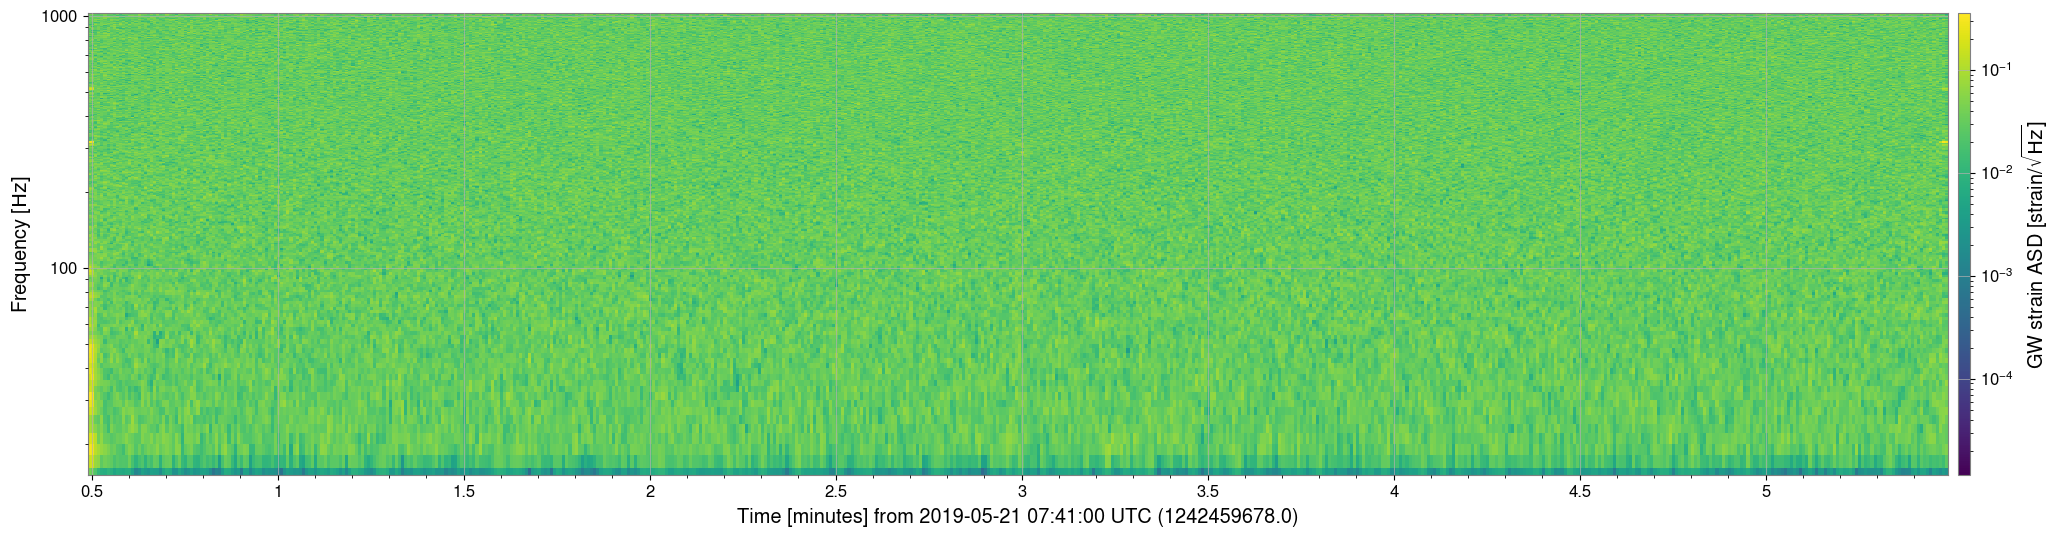

In [3]:
from pycwb.modules.data_conditioning import data_conditioning
from pycwb.modules.plot import plot_spectrogram

strains, nRMS = data_conditioning(config, data)

# plot the spectrogram for L1
plt = plot_spectrogram(strains[0], gwpy_plot=True)
ax = plt.gca()
ax.set_ylim(15,1024)

strains, nRMS

calculate coherence

In [4]:
from pycwb.modules.coherence import coherence

# calculate coherence
fragment_clusters = coherence(config, strains, nRMS)

25-04-14 02:02:37 - coherence - INFO - Start coherence in parallel
25-04-14 02:02:39 - _coherence_single_res - INFO - level : 10	 rate(hz) : 2	 layers : 1024	 df(hz) : 1.000000	 dt(ms) : 500.000000 
max energy in units of noise variance: 7.95643 
thresholds in units of noise variance: Eo=8.37239 Emax=16.7448 
live time in zero lag: 280 
lag | clusters | pixels 
  0 |        7 |     54 
Coherence time for single level: 1.820801 s
25-04-14 02:02:39 - _coherence_single_res - INFO - level : 8	 rate(hz) : 8	 layers : 256	 df(hz) : 4.000000	 dt(ms) : 125.000000 
max energy in units of noise variance: 8.62635 
thresholds in units of noise variance: Eo=8.49005 Emax=16.9801 
live time in zero lag: 280 
lag | clusters | pixels 
  0 |        5 |    153 
Coherence time for single level: 1.767497 s
25-04-14 02:02:39 - _coherence_single_res - INFO - level : 9	 rate(hz) : 4	 layers : 512	 df(hz) : 2.000000	 dt(ms) : 250.000000 
max energy in units of noise variance: 8.30387 
thresholds in units of no

In [ ]:
# fragment_clusters

In [ ]:
# # %matplotlib inline
# from gwpy.spectrogram import Spectrogram
# for fragment_cluster in fragment_clusters:
#   for cluster in fragment_cluster.clusters:
#       merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

#       plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
#       plt.colorbar()

supercluster

In [5]:
from pycwb.modules.super_cluster import supercluster
from pycwb.types.network import Network

network = Network(config, strains, nRMS)

pwc_list = supercluster(config, network, fragment_clusters, strains)

25-04-14 02:02:54 - set_time_shift - INFO - lag step: 1.0
25-04-14 02:02:54 - set_time_shift - INFO - number of time lags: 1
25-04-14 02:02:56 - sparse_table_from_fragment_clusters - INFO - ----------------------------------------
25-04-14 02:02:56 - sparse_table_from_fragment_clusters - INFO - Sparse series time: 1.40 s
25-04-14 02:02:56 - sparse_table_from_fragment_clusters - INFO - ----------------------------------------
25-04-14 02:02:57 - supercluster - INFO - -> Processing lag=0 ...
25-04-14 02:02:57 - supercluster - INFO -    --------------------------------------------------
25-04-14 02:02:57 - supercluster - INFO -     coher clusters|pixels      :     67|982
25-04-14 02:02:57 - supercluster - INFO -     super clusters|pixels      :      7|519
25-04-14 02:02:57 - supercluster - INFO -    defrag clusters|pixels      :      7|519
25-04-14 02:02:57 - supercluster - INFO -    subnet clusters|pixels      :      1|370
25-04-14 02:02:57 - supercluster - INFO - Supercluster done
25-04

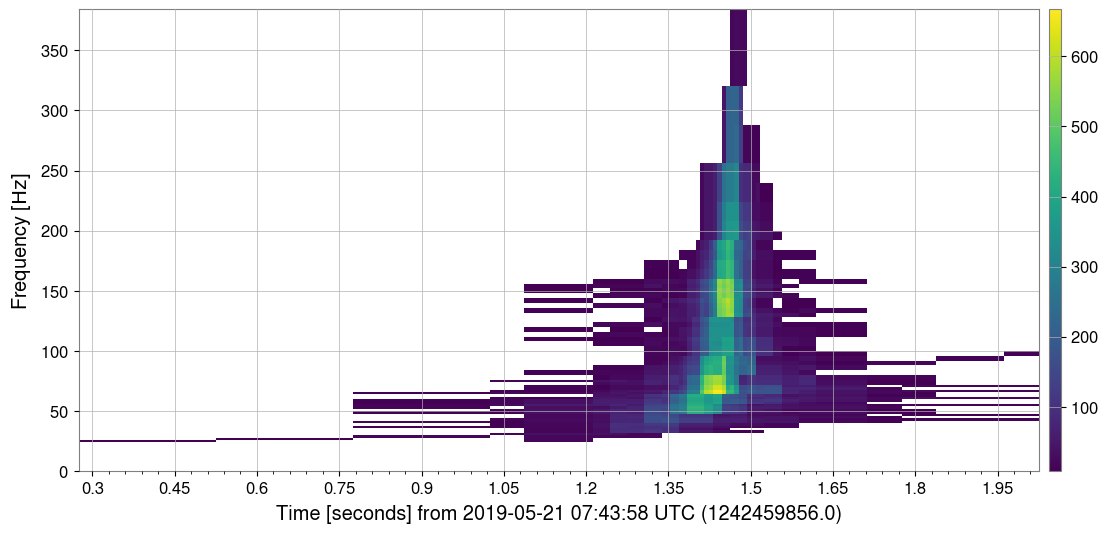

In [14]:
# %matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in pwc_list[0].clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

    plt = Spectrogram(merged_map, t0=t0-150+start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

**I made a change: t0=start -> t0=t0-150+start to make sure x-axis shows the correct time. And the same for the several following cells.**

Likelihood

In [15]:
from pycwb.modules.likelihood import likelihood

events, clusters, skymap_statistics = likelihood(config, network, pwc_list)

25-04-14 02:27:41 - likelihood - INFO - -------------------------------------------------------
25-04-14 02:27:41 - likelihood - INFO - -> Processing 1 clusters in lag=0
25-04-14 02:27:41 - likelihood - INFO -    ----------------------------------------------------
25-04-14 02:27:44 - _likelihood - INFO - Selected core pixels: 1
25-04-14 02:27:44 - _likelihood - INFO -    cluster-id|pixels:     1|370
25-04-14 02:27:44 - _likelihood - INFO - 	 -> SELECTED !!!
25-04-14 02:27:44 - likelihood - INFO - -------------------------------------------------------
25-04-14 02:27:44 - likelihood - INFO - Total events: 1
25-04-14 02:27:44 - likelihood - INFO - Total time: 3.75 s
25-04-14 02:27:44 - likelihood - INFO - -------------------------------------------------------
mchirp_2g : 1 1 4.40e+01 3.027 150.061 0.000 1.038 



plot statistics

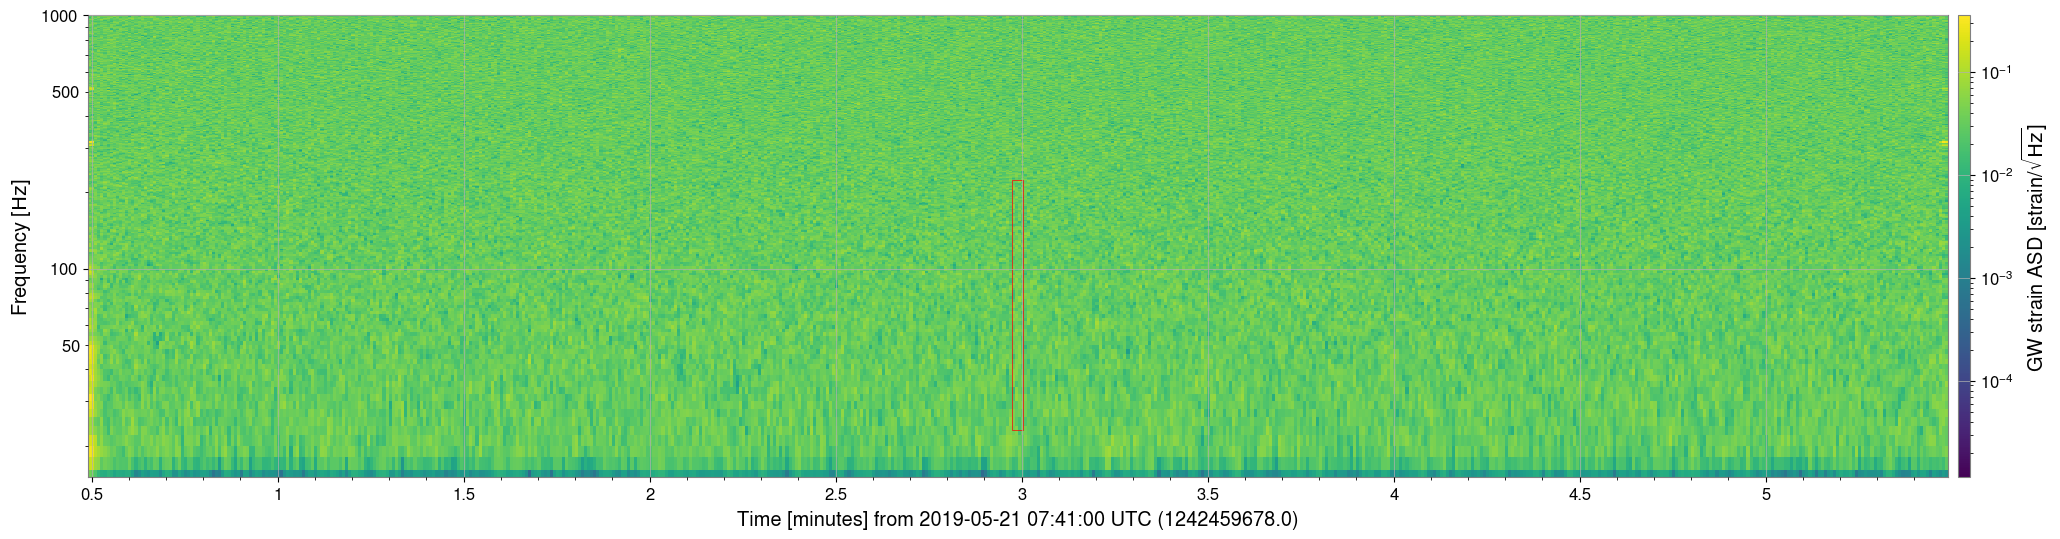

In [16]:
# %matplotlib inline
from pycwb.modules.plot import plot_event_on_spectrogram

plt = plot_event_on_spectrogram(strains[0], events)
plt.show()

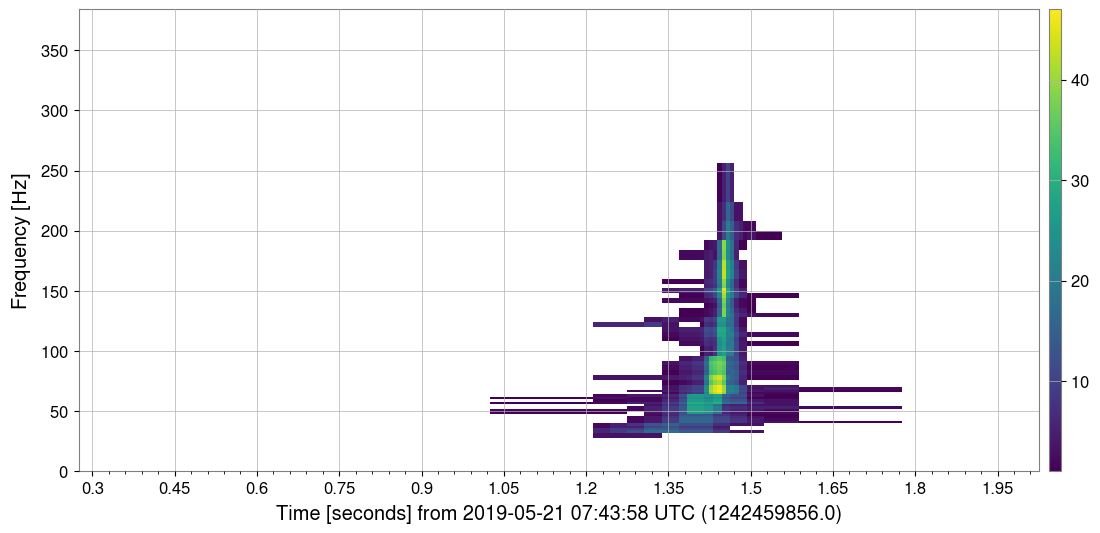

In [17]:
# %matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

    plt = Spectrogram(merged_map, t0=t0-150+start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

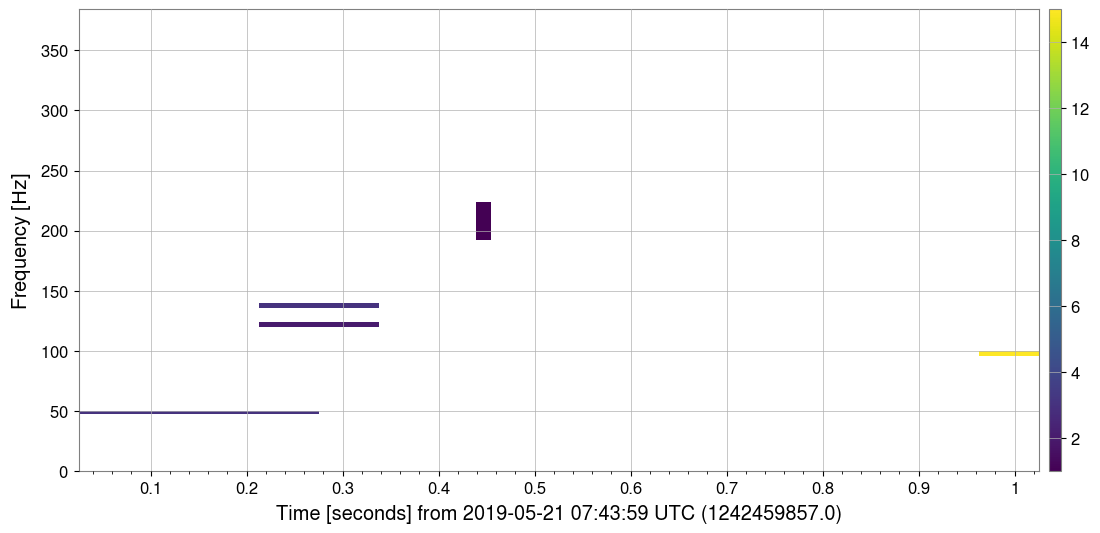

In [18]:
# %matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("null")

    plt = Spectrogram(merged_map, t0=t0-150+start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

(149.0, 150.75)

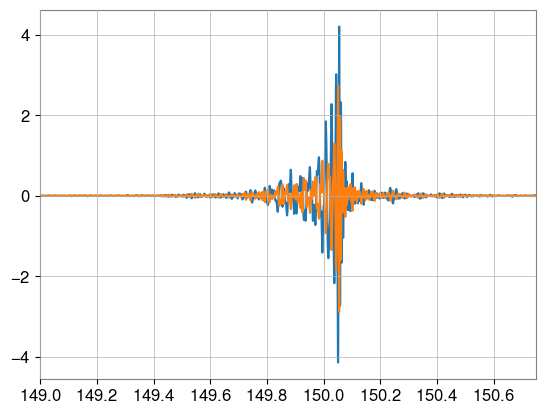

In [19]:
from pycwb.modules.reconstruction import get_network_MRA_wave
from pycwb.modules.plot.waveform import plot_reconstructed_waveforms
from matplotlib import pyplot as plt

event = events[0]
cluster = clusters[0]
reconstructed_waves = get_network_MRA_wave(config, cluster, config.rateANA, config.nIFO, config.TDRate,
                                               'signal', 0, True)
for reconstructed_wave in reconstructed_waves:
  plt.plot(reconstructed_wave.sample_times, reconstructed_wave.data)
plt.xlim((event.left[0], event.left[0] + event.stop[0] - event.start[0]))

In [20]:
events

[Event(nevent=1, ndim=2, run=0, rho=[15.651582717895508, 14.936389996515237, 0], netcc=[0, 0, 0], neted=[0, 0, 0, 0, 0], gnet=0.5748118162155151, anet=0.12673026323318481, inet=0.0, ecor=495.2447509765625, norm=6.891351222991943, ECOR=0.0, penalty=0, likelihood=665.4969482421875, factor=0.0, range=[0], chirp=[0, 44.00021743774414, 3.027019500732422, 0.9875091910362244, 0.8859060406684875, 0.933883011341095], eBBH=[], usize=0.0, ifo_list=[], eventID=[1, 0], type=[1], name=[], log=[], rate=[0, 0], volume=[370, 149], size=[151, 150], gap=[0, 0], lag=[0.0, 0.0, 0.0, 0.0], slag=[0, 0, 0], strain=[2.6069535980258567e-45], phi=[279.84375, 0, 274.53102865302935, 257.6953125], theta=[75.83047778522995, 0, 14.169522214770055, 111.38194274902344], psi=[0.0], iota=[0.0], bp=[0.8409342104858897, -0.6128354419842369], bx=[-0.4339946475654604, 0.3741226278236298], time=[1242459857.4323273, 1242459857.4376523], gps=[1242459707.3999023, 1242459707.3999023], right=[149.25, 149.25], left=[149.0, 149.0], 